This notebook demonstrates how to build a classifier for multi-channel timeseries data using deep learning techniques. It can be used, for example, for human activity recognition (HAR) using multi-sensor data from a wearable device. The technique is heavily derived from [this paper](https://www.mdpi.com/1424-8220/16/1/115/htm). It uses a combination of CNN and LSTM layers.

My approach is to first generate random samples of 3-channel 10 second timeseries at 6.5Hz from two different classes, which serves as both training and test data for this demonstration. Subsequently I build and train the classifier using `keras`.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from tensorflow.keras.layers import Convolution2D, Dense, Flatten, LSTM, MaxPooling2D, Reshape, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

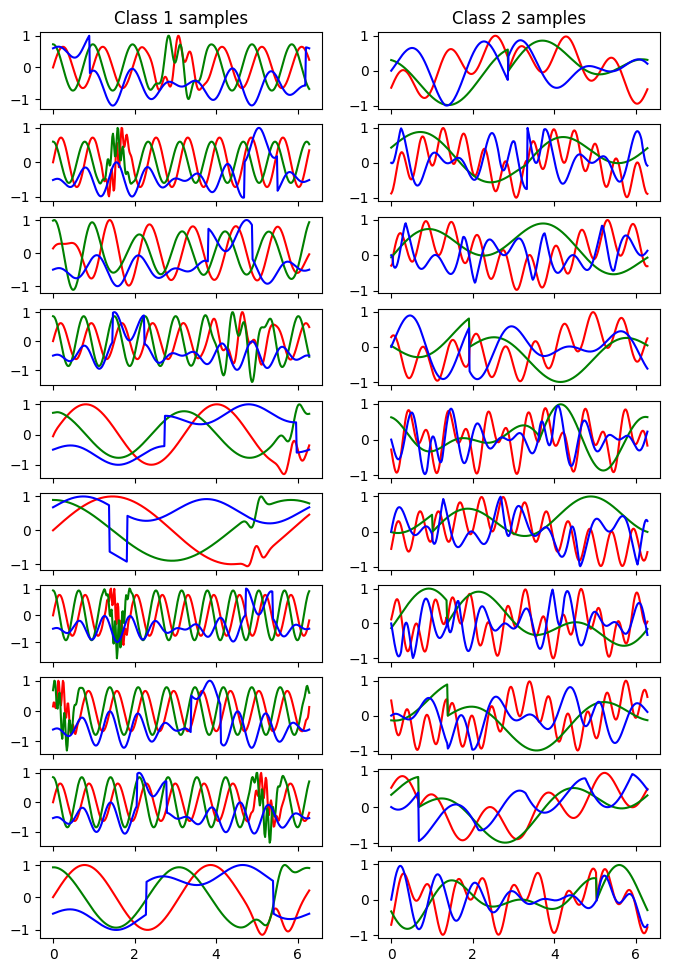

In [2]:
def generate_class1_sample(x):
    """
    Generate a sample datapoint from class 1
    """
    sample = np.empty([len(x), 3])

    r = np.random.uniform(1, 10)
    scale_r = np.random.uniform(1e-4, 4)
    roll_r = np.random.choice(len(x))
    sample[:, 0] = np.roll(np.real(signal.morlet(len(x), r, scale_r)), roll_r) + np.sin(r * x)
    sample[:, 1] = np.roll(np.imag(signal.morlet(len(x), r, scale_r)), roll_r) + np.cos(r * x)
    sample[:, 2] = np.roll(signal.square(x, 1. / r), roll_r) + np.sin(x) * np.cos(r * x)

    for j in range(3):
        sample[:, j] = sample[:, j] / max(sample[:, j])

    return sample


def generate_class2_sample(x):
    """
    Generate a sample datapoint from class 2
    """
    sample = np.empty([len(x), 3])

    r1 = np.random.uniform(1, 10)
    r2 = np.random.uniform(1, 10)
    scale_r = np.random.uniform(1e-4, 4)
    roll_r = np.random.choice(len(x))

    sample[:, 0] = np.roll(np.sin(r1 * x) * np.cos(r2 * x), roll_r)
    sample[:, 1] = np.roll(np.sin(r1 / r2 * x) * np.cos(r2 / r1 * x), roll_r)
    sample[:, 2] = np.roll(signal.sawtooth(x * scale_r, 1. / r1), roll_r)*np.sin(r1*x)

    return sample


def plot_10_samples():
    """ 
    A helper function to visualize some samples
    """

    length_per_sample = int(6.5 * 60)

    x = np.linspace(0, 2 * np.pi, length_per_sample)
    y = np.imag(signal.morlet(length_per_sample))

    nplots = 10
    fig, axes = plt.subplots(nplots, 2, sharex=True)

    for j in range(nplots):
        ax = axes[j][0]
        sample = generate_class1_sample(x)
        ax.plot(x, sample[:, 0], 'r-')
        ax.plot(x, sample[:, 1], 'g-')
        ax.plot(x, sample[:, 2], 'b-')

        ax = axes[j][1]
        sample = generate_class2_sample(x)
        ax.plot(x, sample[:, 0], 'r-')
        ax.plot(x, sample[:, 1], 'g-')
        ax.plot(x, sample[:, 2], 'b-')

    ax = axes[0][0]
    ax.set_title("Class 1 samples")
    ax = axes[0][1]
    ax.set_title("Class 2 samples")
    
    fig.set_dpi(100)
    fig.set_figwidth(8)
    fig.set_figheight(12)
    
plot_10_samples()

The above image depicts 10 samples from each class 1 (left column) and class 2 (right column). Although the functions used to generate members of each class are quite different, it isn't obvious from visual inspection how to tell them apart. In this sense, we have ourselves a non-trivial problem for deep learning.

In [3]:
def generate_samples_for_keras(nsamples):
    """
    A helper function to quickly generate a given number of samples. Each sample is randomly
    assigned to either class 1 or class 2 and then generated using the functions above. 
    """

    length_per_sample = int(6.5 * 60)
    x = np.linspace(0, 2 * np.pi, length_per_sample)

    X = np.empty([nsamples, len(x), 3])
    Y = np.empty([nsamples, 1])
    for j in range(nsamples):
        Y[j] = np.random.choice([0., 1.])
        if Y[j] == 0:
            X[j, :, :] = generate_class1_sample(x)
            #X[j, :, :] = 0
        else:
            X[j, :, :] = generate_class2_sample(x)
            #X[j, :, :] = 1
    return X, Y

X_train, y_train = generate_samples_for_keras(8000)
X_test, y_test = generate_samples_for_keras(2000)

In [4]:
# Reshape the data for keras:
# (n_samples, n_timesteps, n_dims, n_features)

# Note: I'm using Convolution2D below despite the fact that this is a 1-D dataset
# This is an artifact. While experimenting with the model form I considered
# treating the (65 x 1 x 3) features as a (65 x 3 x 1) bitmap.

X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

X_train.shape, X_test.shape

((8000, 390, 1, 3), (2000, 390, 1, 3))

In [5]:
# Assemble the keras model 

model = Sequential()

model.add(Convolution2D(
    filters=16,
    kernel_size=(5, 1),  # Filter is 1D as per ntoe above
    activation='relu',   
    input_shape=X_train.shape[1:]
))

model.add(MaxPooling2D(
    pool_size=(5, 1)
))
          
model.add(Reshape((-1, 16)))

model.add(LSTM(
    units=128, 
    activation='relu', 
    return_sequences=True
))

model.add(LSTM(
    units=128, 
    activation='relu'
))

model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 386, 1, 16)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 77, 1, 16)         0         
_________________________________________________________________
reshape (Reshape)            (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         74240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dens

In [6]:
# Train the model 

opt = Adam(lr=0.00001, decay=1e-6)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

model.fit(X_train,
          y_train,
          epochs=10,
          validation_data=(X_test, y_test),
          batch_size=100
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 0.6903 - acc: 0.5092 - val_loss: 0.6888 - val_acc: 0.5325
Epoch 2/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 0.6870 - acc: 0.5554 - val_loss: 0.6853 - val_acc: 0.5800
Epoch 3/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 0.6828 - acc: 0.6195 - val_loss: 0.6802 - val_acc: 0.6580
Epoch 4/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 0.6760 - acc: 0.6867 - val_loss: 0.6719 - val_acc: 0.6890
Epoch 5/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 0.6640 - acc: 0.7046 - val_loss: 0.6553 - val_acc: 0.7045
Epoch 6/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 0.6388 - acc: 0.7475 - val_loss: 0.6174 - val_acc: 0.7660
Epoch 7/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 0.5463 - acc: 0.8039 - val_loss: 0.3885 - val_acc: 

**Conclusion:**

This model achieves an accuracy on both the training set and validation of ~94%, showing that it has learned well the difference between the two classes without overfitting.

The technique demonstrated in this notebook is rather flexible, and an unlimited number of variations of the model form can be constructed by adding hidden layers and changing the number of hidden nodes within each layer. This flexibility is one of the great strengths of deep learning - a wide variety of patterns can be learned with enough time and data. 

I hope you find this notebook useful and wish you luck in your deep learning adventures. Feel free to contact me at aniketaranake (at) gmail (dot) com with any questions.